In [4]:
import torch
import torch.nn as nn

class SimpleMLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=3, output_dim=1):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        a1 = self.fc1(x)
        h1 = self.relu1(a1)
        a2 = self.fc2(h1)
        return a2, a1

# Example network
mlp = SimpleMLP()
x0 = torch.randn(1, 2)  # some input

# Forward pass to record pre-activations
output, pre_activations = mlp(x0)

# Suppose you want linear region constraints for first layer
with torch.no_grad():
    a1 = mlp.fc1(x0)
    # For each neuron, is it active?
    active = a1[0] > 0
    # For each neuron, linear constraint wrt input x:
    # For neuron i: a1_i = w_i1*x1 + w_i2*x2 + b_i > 0  (if active), < 0 if inactive
    for i in range(mlp.fc1.out_features):
        w = mlp.fc1.weight[i]
        b = mlp.fc1.bias[i].item()
        sign = ">" if active[i] else "<"
        print(f"For neuron {i}: {w[0].item():.2f}*x1 + {w[1].item():.2f}*x2 + {b:.2f} {sign} 0")

For neuron 0: 0.14*x1 + -0.54*x2 + -0.29 < 0
For neuron 1: 0.63*x1 + -0.35*x2 + 0.42 > 0
For neuron 2: 0.22*x1 + -0.70*x2 + -0.29 > 0


/tmp/ipykernel_4106696/867349275.py:23: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X1, X2, Z, levels=[0], colors=f"C{neuron}", linestyles='--', linewidths=2,


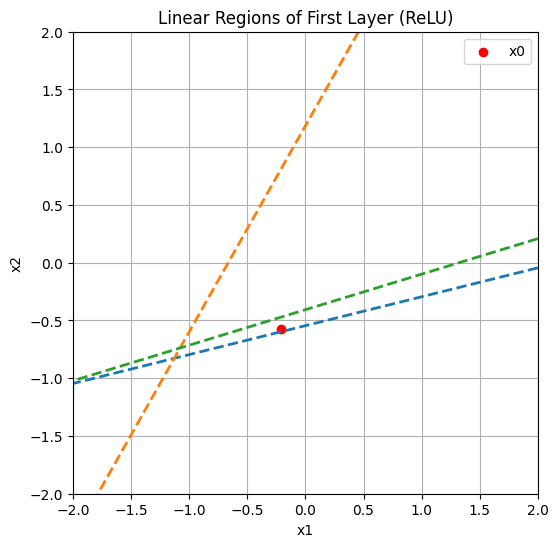

In [5]:
import numpy as np

import matplotlib.pyplot as plt

# Create a grid of (x1, x2) values
x1 = np.linspace(-2, 2, 100)
x2 = np.linspace(-2, 2, 100)
X1, X2 = np.meshgrid(x1, x2)
grid = np.stack([X1.ravel(), X2.ravel()], axis=1)
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Compute pre-activations for all grid points
with torch.no_grad():
    a1_grid = mlp.fc1(grid_tensor).numpy()

# Plot the linear region boundaries for each neuron in the first layer
plt.figure(figsize=(6, 6))
plt.title("Linear Regions of First Layer (ReLU)")

for neuron in range(mlp.fc1.out_features):
    # The boundary is where pre-activation == 0
    Z = a1_grid[:, neuron].reshape(X1.shape)
    plt.contour(X1, X2, Z, levels=[0], colors=f"C{neuron}", linestyles='--', linewidths=2, 
                label=f"Neuron {neuron} boundary")

# Optionally, plot the input point
plt.scatter(x0[0,0], x0[0,1], color='red', label='x0')
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import torch
import torch.nn as nn

class SimpleMLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dims=[4, 4], output_dim=1):
        super().__init__()
        layers = []
        last_dim = input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(last_dim, h_dim))
            layers.append(nn.ReLU())
            last_dim = h_dim
        layers.append(nn.Linear(last_dim, output_dim))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

# Example use
model = SimpleMLP(input_dim=2, hidden_dims=[4, 4], output_dim=1)
x = torch.randn(1, 2)
y = model(x)
print(y)

tensor([[-0.1712]], grad_fn=<AddmmBackward0>)


In [8]:
import math

def count_linear_regions(input_dim, layer_widths):
    regions = 1
    d = input_dim
    for n in layer_widths:
        # sum_{j=0}^d C(n, j)
        s = sum(math.comb(n, j) for j in range(d+1))
        regions *= s
    return regions

input_dim = 2
hidden_layers = [4, 4]
print("Upper bound of linear regions:", count_linear_regions(input_dim, hidden_layers))
# Output: 81

Upper bound of linear regions: 121


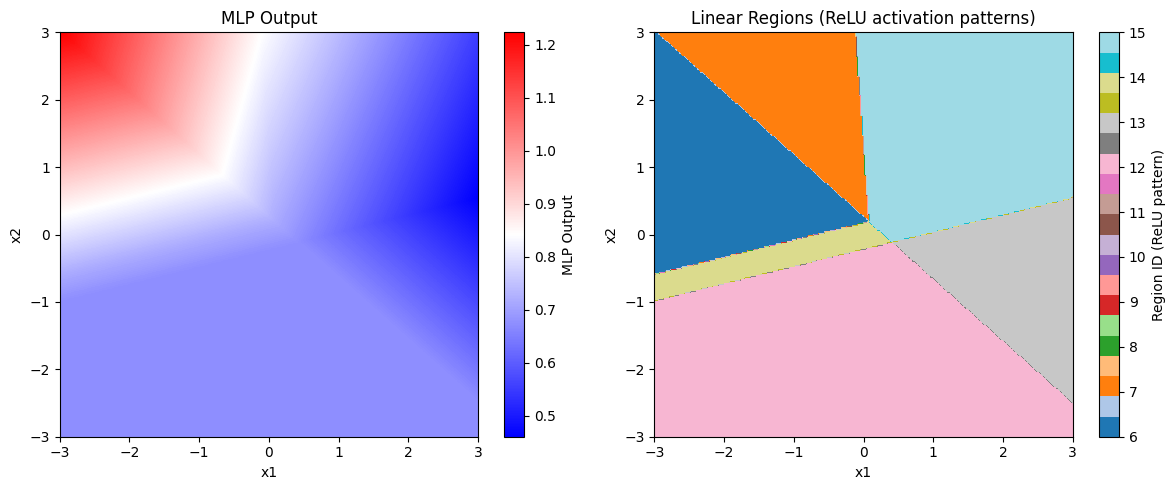

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Build a small MLP: 2-2-2-1 with ReLU
class SmallMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 2)
        self.fc3 = nn.Linear(2, 1)

    def forward(self, x):
        x = self.fc1(x)
        a1 = (x > 0).int()  # record ReLU pattern
        x = torch.relu(x)
        x = self.fc2(x)
        a2 = (x > 0).int()
        x = torch.relu(x)
        x = self.fc3(x)
        return x, a1, a2

mlp = SmallMLP()

# Create grid of input points
res = 300
xv, yv = np.meshgrid(np.linspace(-3, 3, res), np.linspace(-3, 3, res))
points = np.stack([xv.ravel(), yv.ravel()], axis=-1)
inputs = torch.tensor(points, dtype=torch.float32)

# Pass through MLP and record ReLU patterns
with torch.no_grad():
    outputs, a1, a2 = mlp(inputs)
    patterns = torch.cat([a1, a2], dim=1).numpy()  # shape: [N, 4]
    patterns_int = patterns.dot(1 << np.arange(patterns.shape[1]))

outputs = outputs.numpy().reshape(res, res)
patterns_int = patterns_int.reshape(res, res)

# Plotting function output
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(outputs, extent=[-3,3,-3,3], origin='lower', aspect='auto', cmap='bwr')
plt.colorbar(label='MLP Output')
plt.title('MLP Output')
plt.xlabel('x1')
plt.ylabel('x2')

# Plotting linear regions
plt.subplot(1,2,2)
plt.imshow(patterns_int, extent=[-3,3,-3,3], origin='lower', aspect='auto', cmap='tab20')
plt.colorbar(label='Region ID (ReLU pattern)')
plt.title('Linear Regions (ReLU activation patterns)')
plt.xlabel('x1')
plt.ylabel('x2')

plt.tight_layout()
plt.show()

In [11]:
import numpy as np

# Suppose f1 and f2 are piecewise-linear functions with breakpoints at:
f1_breaks = np.array([-1, 0, 1])   # divides x1 axis into 3 regions
f2_breaks = np.array([-2, 0.5, 2]) # divides x2 axis into 3 regions

# The input space is cut into 3x3 = 9 rectangles
regions = []
for i in range(len(f1_breaks)-1):
    for j in range(len(f2_breaks)-1):
        # region: x1 in [f1_breaks[i], f1_breaks[i+1]) and x2 in [f2_breaks[j], f2_breaks[j+1])
        regions.append(((f1_breaks[i], f1_breaks[i+1]), (f2_breaks[j], f2_breaks[j+1])))
print("Total regions:", len(regions))

Total regions: 4


In [6]:
from kan import KAN
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import numpy as np

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.get_default_dtype()

class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

args_dict = {
    'grid': 5,
    'k': 3,
    'seed': 2024,
    'mode': 'default',
    'init_mode': 'kaiming_in',
    'moon_noise': 0.0,
    'bounds': (-1,1),
    'optimizer': 'LBFGS',
    'lamb': 0.0,
    'lamb_l1': 1.0,
    'lamb_entropy': 2.0,
    'lamb_coef': 0.0,
    'lamb_coefdiff': 0.0
}
args = Args(**args_dict)

# Create uniformly distributed train and test datasets with two labels
rng = np.random.RandomState(args.seed)

n_samples = 1000

bounds = args.bounds

# Train data
train_input = rng.uniform(low=bounds[0], high=bounds[1], size=(n_samples, 2))
train_label = rng.randint(0, 2, size=n_samples)

# Test data
test_input = rng.uniform(low=bounds[0], high=bounds[1], size=(n_samples, 2))
test_label = rng.randint(0, 2, size=n_samples)

dataset = {}
dataset['train_input'] = torch.from_numpy(train_input).type(dtype).to(device)
dataset['test_input'] = torch.from_numpy(test_input).type(dtype).to(device)
dataset['train_label'] = torch.from_numpy(train_label).type(torch.long).to(device)
dataset['test_label'] = torch.from_numpy(test_label).type(torch.long).to(device)

X = dataset['train_input']
y = dataset['train_label']

model = KAN(
    width=[2,2],
    device=device,
    grid=args.grid, k=args.k, seed=args.seed,
    mode=args.mode,
    init_mode=args.init_mode,
    )

def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).type(dtype))

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).type(dtype))

results = model.fit(
    dataset, 
    opt="LBFGS", 
    steps=20, 
    metrics=(train_acc, test_acc), 
    loss_fn=torch.nn.CrossEntropyLoss(),
    lamb=args.lamb,
    lamb_l1=args.lamb_l1,
    lamb_entropy=args.lamb_entropy,
    lamb_coef=args.lamb_coef,
    lamb_coefdiff=args.lamb_coefdiff
    );


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.32e-01 | test_loss: 8.34e-01 | reg: 0.00e+00 | :  25%|▎| 5/20 [00:00<00:02,  6.08it/

| train_loss: 8.31e-01 | test_loss: 8.34e-01 | reg: 4.27e+00 | : 100%|█| 20/20 [00:03<00:00,  6.43it

saving model version 0.1


In [ ]:
import torch
import numpy as np

# Parameters
n_grid_points = 10000  # the higher, the more accurate (but slower)
bounds = args.bounds

# Build a dense 2D grid in input space
x1 = np.linspace(bounds[0], bounds[1], n_grid_points)
x2 = np.linspace(bounds[0], bounds[1], n_grid_points)
xx, yy = np.meshgrid(x1, x2)
grid_points = np.stack([xx.ravel(), yy.ravel()], axis=1)
X_grid = torch.from_numpy(grid_points).float().to(device)

# Get region "codes" for each point
def get_region_code(model, x):
    """
    Returns, for each sample (row of x), a tuple of (univariate function segments encountered at all possible nodes and layers).
    If model exposes breakpoints and univariate funcs, extract segment index per input.
    Here we use the KAN model's get_region_id method (if available). Otherwise, fallback to output difference check.
    """
    try:
        # supported in official KAN repo: https://github.com/KindXiaoming/kolmogorov-arnold-networks
        with torch.no_grad():
            region_ids = model.get_region_id(x)  # shape: (N, L)
        return [tuple(r.tolist()) for r in region_ids.cpu()]
    except AttributeError:
        # fallback: round output differences (not exact)
        out = model(x)
        # To avoid small float errors, round heavily
        return [tuple(np.round(o, 6)) for o in out.detach().cpu().numpy()]

region_codes = get_region_code(model, X_grid)

# Count unique regions empirically
unique_region_codes = set(region_codes)
n_regions = len(unique_region_codes)
print(f"Estimated number of linear regions in 2D input space: {n_regions}")

# Optionally, visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
region_code_list = list(unique_region_codes)
region_to_color = {code: i for i, code in enumerate(region_code_list)}
img = np.array([region_to_color[code] for code in region_codes]).reshape(n_grid_points, n_grid_points)
plt.imshow(img, extent=[bounds[0], bounds[1], bounds[0], bounds[1]], origin='lower', cmap='tab20')
plt.title('Empirical KAN Linear Regions')
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar(label='Region Label')
plt.tight_layout()
plt.show()